<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_ai_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI data analysis

### Setup
- Install & import necessary libraries
- Mount drive
- Import and define handy variables 

In [ ]:
# Sometimes the colab fastai version can be wrong, so we reinstall with no cache
# reinstalling, and restarting runtime should fix any major issues. 
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [ ]:
import pandas as pd

from fastai.vision.all import *
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
%rm -rf /content/fyp

In [ ]:
%cd /content
!git clone https://github.com/WRFitch/fyp.git

In [ ]:
# Import fyputil library
%cd /content/fyp/src/fyputil
import constants as c
import fyp_utils as fyputil
%cd /content

### Data Setup

In [3]:
ghg_df = pd.read_csv(c.ghg_csv)
ghg_df = fyputil.normGhgDfProperly(ghg_df)

In [4]:
def getGhgsAsArr(img_path):
  return fyputil.getGhgsAsArr(img_path, ghg_df)

def imgIsInDf(path):
  return fyputil.imgIsInDf(path, ghg_df)

def getGhgImgs(path):
  return get_image_files(path).filter(imgIsInDf)

In [5]:
# TODO implement multiple transforms pipeline
# TODO revisit image normalisation
# TODO ensure random data splitter is ok 

ghg_block = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = getGhgImgs,
    get_y = getGhgsAsArr,
    splitter  = RandomSplitter(),
    item_tfms = Resize(224)
)

ghg_dl = ghg_block.dataloaders(c.big_png_dir)

In [ ]:
ghg_dl.show_batch(nrows=9, max_n=9, figsize = (50,50))

In [ ]:
ghg_block.summary(c.big_png_dir)

## Training

### Image Recognition and Feature Extraction. 

- Train image-based predictor to guess greenhouse gas concentrations based on 1km square of land. 
  - Transfer an ImageNet predictor to work top-down
  - Start by predicting one ghg and expand from there
- Use image predictor to extract a basic feature set by slicing the network at different points. The idea is to limit the amount of data going into the tabular recommender, while transferring as much useful data as possible. We want to implicitly extract GHG-emitting features of each image without losing any detail, as a form of convolutional preprocessing. 


In [8]:
from fastai.metrics import rmse

In [9]:
# Returning an array of rmse array values. This might be unnecessary, or broken
def rmseArr(inp, targ):
  arr = []
  for val in range(0, len(inp)):
    arr.append(rmse(inp[val], targ[val]))
  return arr

def testRmse(inp, targ):
  out = rmse(inp, targ)
  return out

def sumRmse(inp, targ):
  return sum(rmseArr(inp, targ))

In [53]:
test = cnn_learner(ghg_dl, resnet101, y_range=(0,100), metrics=rmse)

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

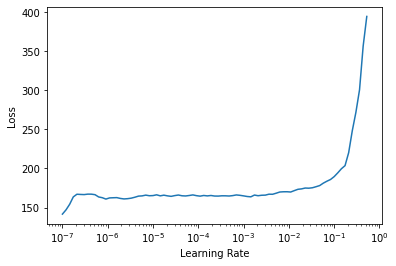

In [57]:
test.lr_find() 

In [56]:
test.save("testing my own error metric")

Path('models/testing my own error metric.pth')

In [51]:
test.load("testing my own error metric")

In [ ]:
test.fine_tune(1, 0.001)

In [ ]:
test.show_results(ds_idx=1, dl=ghg_dl, nrows=9, max_n=9, figsize = (50,50)) 

In [ ]:
new_model = "mrghg_060321-resnet101_increased_dataset_size_to_4k"
test.export(f"{c.model_dir}/{new_model}.pkl")

### Exporting main network 

In [ ]:
learn = cnn_learner(ghg_dl, resnet152, y_range=(0, 100),  metrics=[rmse, R2Score])
name = "learner test"
learn.save(name)

In [ ]:
learn.load(name)

In [ ]:
# TODO examine 3d representation of problem space re: local optima 
learn.lr_find()

In [ ]:
# TODO When cutting release branch, update these to be the actual learning rates used for training. 
# TODO experiment with different discriminative learning rates, both linear and wacky functional. 
lr = 0.03
finelr = 0.00002
xfinelr = 1.584893179824576e-05
xxfinelr = 0.0002

In [ ]:
# epochs = 2
learn.fine_tune(1, lr)

In [ ]:
# Saving mid-training, so I can figure out a decent training pathway
learn.save("mid-training")

Path('models/mid-training.pth')

In [ ]:
learn.load("mid-training")

In [ ]:
learn.fine_tune(5, finelr)

In [ ]:
learn.save("fine-tuning")

In [ ]:
learn.fine_tune(5, xfinelr)

In [ ]:
learn.save("xfine-tuning")

In [ ]:
learn.load("xfine-tuning")

In [ ]:
learn.save("xxfine-tuning")

In [ ]:
learn.fine_tune(10, xxfinelr)

## Evaluate Model Performance 

### Plot results 

In [ ]:
learn.show_results(ds_idx=1, dl=ghg_dl, nrows=9, max_n=9, figsize = (50,50))

### Plot model statistics 

#### Plot layer stats

This allows us to see what the mean std and pct activation levels are, letting us see areas of the network that require further analysis 

In [ ]:
learn.activation_stats.plot_layer_stats(151) 

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.activation_stats.color_dim(-4)

### Export the model

#### Cutting a neural encoder
I hope this works

In [ ]:
encoder = create_body(resnet152, cut = -2)

#### Exporting main model


In [ ]:
# Export model so we can use it for other things. Note - this kills the model 
#TODO find better naming convention 
new_model = "mrghg_060321-resnet152_increased_dataset_size_to_4k"
learn.export(f"{c.model_dir}/{new_model}.pkl")

In [ ]:
# Import model and test to see if it hasn't broken in the export process.
imported_learner = load_learner(f"{c.model_dir}/{c.model_name}.pkl")

In [ ]:
# Predict from imported learner
imported_learner.predict(f"{c.png_dir}/-0.73212695655741_51.2533785354393.png")

#### Notes on Image Predictions

A lower learning rate appears to cause slower training with more sophisticated conclusions. Sophistication also appears to arise from a deeper network, but I'm hitting a wall at roughly 0.6 rmse.

Effectively, this network recognises certain features of high-GHG land. Depending on sophistication, this may include airports, power plants, or other rare features, as well as recognising different types of wilderness or residential districts. This will be used to extract a feature set for a tabular recommender, which can then be used to find more accurate readings. 